In [ ]:
import re
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

Using TensorFlow backend.


In [ ]:
train_df=pd.read_csv('/content/drive/My Drive/Colab_Notebooks/Datasets/hatespeech_kaggle/train.csv')
train_df.head(100)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
95,96,0,@user i'll always hope that one day i'll get t...
96,97,0,#model i love u take with u all the time in ...
97,98,0,couple having sex fat naked japanese girls
98,99,0,#hump on that #hump day #humpersð© @ edwa...


In [ ]:
test_df=pd.read_csv('/content/drive/My Drive/Colab_Notebooks/Datasets/hatespeech_kaggle/test.csv')
test_df.head(100)

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."
...,...,...
95,32058,great to see you! look forward to welcoming yo...
96,32059,jackblair - na: #horny #hot #naughty #nasty ...
97,32060,@user @user did u take both of them and pour t...
98,32061,ððððâ¤ï¸ððð» happy fathe...


In [ ]:
for i in range(0,10):
    print(train_df['tweet'][i])

 @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run
@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked
  bihday your majesty
#model   i love u take with u all the time in urð±!!! ððððð¦ð¦ð¦  
 factsguide: society now    #motivation
[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo  
 @user camping tomorrow @user @user @user @user @user @user @user dannyâ¦
the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams   #hate #imagine #actorslife #revolutionschool #girl
we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers  â¦ 
 @user @user welcome here !  i'm   it's so #gr8 ! 


In [ ]:
x_tr = train_df['tweet']
y_tr = train_df['label']
holdout_test = test_df['tweet']

In [ ]:
def clean_up(text):
    text = re.sub('\d+','',text)
    text = re.sub(r'[^\w\s]','',text)
    text = text.encode('ascii', 'ignore').decode('ascii')
    return text

# x_tr = x_tr.apply(clean_up)
# holdout_test = holdout_test.apply(clean_up)

total_data = x_tr.append(holdout_test)
total_data = total_data.apply(clean_up)

In [ ]:
print(train_df.groupby('label')['label'].count())
print('The shape of train is {}'.format(x_tr.shape))
print('The shape of holdout test is {}'.format(holdout_test.shape))

label
0    29720
1     2242
Name: label, dtype: int64
The shape of train is (31962,)
The shape of holdout test is (17197,)


In [ ]:
for i in range(0,10):
    print(x_tr[i])

 @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run
@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked
  bihday your majesty
#model   i love u take with u all the time in urð±!!! ððððð¦ð¦ð¦  
 factsguide: society now    #motivation
[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo  
 @user camping tomorrow @user @user @user @user @user @user @user dannyâ¦
the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams   #hate #imagine #actorslife #revolutionschool #girl
we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers  â¦ 
 @user @user welcome here !  i'm   it's so #gr8 ! 


In [ ]:
max_fatures = 2000
def tokenize(text_frame):
    tokenizer = Tokenizer(num_words=max_fatures, split=' ')
    tokenizer.fit_on_texts(text_frame.values)
    tokenized = tokenizer.texts_to_sequences(text_frame.values)
    padded_seq = pad_sequences(tokenized)
    return padded_seq

# x_tr = tokenize(x_tr)
# x_te = tokenize(holdout_test)

total_data = tokenize(total_data)
x_tr = total_data[:x_tr.shape[0]]
holdout_test = total_data[x_tr.shape[0]:]
print(train_df.groupby('label')['label'].count())
print('The shape of train is {}'.format(x_tr.shape))
print('The shape of holdout test is {}'.format(holdout_test.shape))

label
0    29720
1     2242
Name: label, dtype: int64
The shape of train is (31962, 31)
The shape of holdout test is (17197, 31)


In [ ]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = x_tr.shape[1]))
#model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.35, recurrent_dropout=0.2))
model.add(Dense(512,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 31, 128)           256000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               100864    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 612,177
Trainable params: 612,177
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(x_tr,y_tr, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(25569, 31) (25569,)
(6393, 31) (6393,)


In [ ]:
model.fit(X_train, Y_train, epochs = 7, batch_size=1024, verbose = 1,
         validation_data = (X_test,Y_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25569 samples, validate on 6393 samples
Epoch 1/7
25569/25569 [==============================] - 42s 2ms/step - loss: 0.3589 - accuracy: 0.9153 - val_loss: 0.2521 - val_accuracy: 0.9287
Epoch 2/7
25569/25569 [==============================] - 41s 2ms/step - loss: 0.2350 - accuracy: 0.9302 - val_loss: 0.2113 - val_accuracy: 0.9296
Epoch 3/7
25569/25569 [==============================] - 40s 2ms/step - loss: 0.1676 - accuracy: 0.9405 - val_loss: 0.1428 - val_accuracy: 0.9482
Epoch 4/7
25569/25569 [==============================] - 39s 2ms/step - loss: 0.1243 - accuracy: 0.9542 - val_loss: 0.1360 - val_accuracy: 0.9484
Epoch 5/7
25569/25569 [==============================] - 41s 2ms/step - loss: 0.1095 - accuracy: 0.9592 - val_loss: 0.1372 - val_accuracy: 0.9514
Epoch 6/7
25569/25569 [==============================] - 39s 2ms/step - loss: 0.1020 - accuracy: 0.9618 - val_loss: 0.1398 - val_accuracy: 0.9489
Epoch 7/7
25569/25569 [==============================] - 38s 2ms/step - los

In [ ]:
preds = model.predict(X_test)

Accuracy: 0.9499
F1 score: 0.5866
AUC-ROC: 0.7412
The confusion matrix for the model is
[[5846   91]
 [ 229  227]]


Text(0, 0.5, 'TPR')

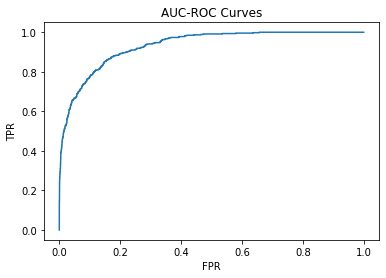

In [ ]:
fpr, tpr, thresh = roc_curve(Y_test, preds)

#print('The metrics for the {} model is as below:'.format(name))
print('Accuracy: {}'.format(round(accuracy_score(Y_test, preds.round()),4)))
print('F1 score: {}'.format(round(f1_score(Y_test, preds.round()),4)))
print('AUC-ROC: {}'.format(round(roc_auc_score(Y_test, preds.round()),4)))
print('The confusion matrix for the model is')
print(confusion_matrix(Y_test,preds.round()))

plt.plot(fpr,tpr)
plt.title('AUC-ROC Curves')
plt.xlabel('FPR')
plt.ylabel('TPR')

In [ ]:
holdout_preds = model.predict(holdout_test)

In [ ]:
print(holdout_preds)

[[4.6595037e-03]
 [2.4706206e-01]
 [1.4499112e-05]
 ...
 [2.5796078e-02]
 [6.7498894e-07]
 [1.6956266e-04]]
